In [26]:
# TODO: da fare ancora
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import torch
from torch import nn
torch.backends.cudnn.benchmark = False
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

import os

In [27]:
class MoviesDataset(Dataset):
    def __init__(self):
        df = pd.read_csv("script_slurm/df.csv")
        df = self.cleaning(df)

        X, y, weights = self.split_XYweights(df)
        
        y = self.discretization(y)
        X.drop('rating_mean', inplace=True, axis=1)

        self.num_classes = y.nunique()
        self.X = torch.FloatTensor(X.values)
        self.y = torch.LongTensor(y)
        self.weights = torch.FloatTensor(weights)


    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx, :], self.y[idx], self.weights[idx]

    def split_XYweights(self, df):
        y = df['rating_mean']
        weights = df['ratings_count']
        X = df.drop(columns=['ratings_count'], axis=1)
        return X, y, weights

    def cleaning(self, df):
        df.dropna(subset=['rating_mean'], inplace=True)
        df_without_tags = df[df.iloc[:, 23:-2].isna().all(axis = 1)]
        df_without_tags_nor_genres = df_without_tags[
            df_without_tags['(no genres listed)'] == 1]
        rows_to_be_deleted = df.loc[df["movieId"].isin(
            df_without_tags_nor_genres["movieId"])].index
        df.drop(rows_to_be_deleted, axis=0, inplace=True)
        df.iloc[:, 23:-2] = df.iloc[:, 23:-2].fillna(0)
        df.drop(['(no genres listed)'], inplace=True, axis=1)
        df_year_without_na = df.year[-pd.isna(df.year)]
        df.year = df.loc[:, 'year'].fillna(
            np.median(df_year_without_na)).astype('int')
        df.drop('movieId', inplace=True, axis=1)
        df.drop_duplicates(inplace=True)
        return df

    def discretization(self, series):
        series = pd.cut(series, bins=5, labels=False)
        return series


In [40]:
class Feedforward(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Feedforward, self).__init__()
        dropout = 0.2
        num_hidden_layers = 3
        self.leaky_relu = nn.LeakyReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

        self.layers = nn.ModuleList()

        for i in range(num_hidden_layers):
            self.layers.append(nn.Sequential(
                self.fc(input_size, hidden_size),
                # self.batch_norm(hidden_size),
                self.leaky_relu(),
                # nn.Dropout(dropout),
            ))

        
        #nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.model(x)


In [29]:
def train_model(model, criterion, optimizer, epochs, data_loader, device):
    model.train()
    loss_values = []
    for epoch in range(epochs):
        for batch_idx, samples in enumerate(data_loader):
            data, targets = samples[0].to(device), samples[1].to(device)
            optimizer.zero_grad()

            # Forward pass
            y_pred = model(data)

            # Compute Loss
            loss = criterion(y_pred.squeeze(), targets)
            loss_values.append(loss.item())
            # print('Epoch {} train loss: {}'.format(epoch, loss.item()))

            # Backward pass
            loss.backward()
            optimizer.step()

    return model, loss_values

In [30]:
def evaluate_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_val = []

    for batch_idx, samples in enumerate(data_loader):
        data, targets = samples[0].to(device), samples[1].to(device)
        y_pred.append(model(data))
        y_val.append(targets)
    y_pred = torch.stack(y_pred).squeeze()
    y_val = torch.stack(y_val).squeeze()
    y_pred = y_pred.argmax(dim=1, keepdim=True).squeeze()
    print(classification_report(y_val.cpu(), y_pred.cpu(), zero_division=0))

In [31]:
def test_model(model, data_loader, device):
    model.eval()
    y_pred = []
    y_test = []

    for batch_idx, samples in enumerate(data_loader):
        data, targets = samples[0].to(device), samples[1].to(device)
        y_pred.append(model(data))
        y_test.append(targets)
    y_pred = torch.stack(y_pred).squeeze()
    y_test = torch.stack(y_test).squeeze()
    y_pred = y_pred.argmax(dim=1, keepdim=True).squeeze()
    print(classification_report(y_test.cpu(), y_pred.cpu(), zero_division=0))


In [32]:
#if __name__ == "__main__":
dataset = MoviesDataset()
train_idx, test_idx = train_test_split(np.arange(len(dataset)), test_size=0.2, stratify=dataset.y, random_state=42)
train_idx, val_idx = train_test_split(train_idx, test_size=0.2, stratify=dataset.y[train_idx], random_state=42)

# MinMaxScale training, validation and testing set su year e title_length
X_train = dataset.X[train_idx]
X_val = dataset.X[val_idx]
X_test = dataset.X[test_idx]

train_year_max = torch.max(X_train[:,1])
train_year_min = torch.min(X_train[:,1])
dataset.X[train_idx, 1] = (X_train[:,1] - train_year_min)/(train_year_max - train_year_min)
dataset.X[val_idx, 1] = (X_val[:,1] - train_year_min)/(train_year_max - train_year_min)
dataset.X[test_idx, 1] = (X_test[:,1] - train_year_min)/(train_year_max - train_year_min)

train_title_length_max = torch.max(X_train[:,2])
train_title_length_min = torch.min(X_train[:,2])
dataset.X[train_idx, 2] = (X_train[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)
dataset.X[val_idx, 2] = (X_val[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)
dataset.X[test_idx, 2] = (X_test[:,2] - train_title_length_min)/(train_title_length_max - train_title_length_min)


# Creating sampler to manage unbalancing classes
def class_weights(y):
    class_count = torch.bincount(y)
    class_weighting = 1. / class_count
    sample_weights = class_weighting[y]   # sarebbe np.array([weight[t] for t in y_train])
    return sample_weights

y_train = dataset.y[train_idx]

sample_weights = class_weights(y_train)
sampler_class_frequency = WeightedRandomSampler(sample_weights, len(train_idx))

# MinMaxScaling ratings_count
weights_train = dataset.weights[train_idx] 
weights_val = dataset.weights[val_idx]
weights_test = dataset.weights[test_idx] 

weights_train_max = torch.max(weights_train)
weights_train_min = torch.min(weights_train)
dataset.weights[train_idx]  = (weights_train - weights_train_min) / (weights_train_max - weights_train_min)
dataset.weights[val_idx] = (weights_val - weights_train_min) / (weights_train_max - weights_train_min)
dataset.weights[test_idx] = (weights_test - weights_train_min) / (weights_train_max - weights_train_min)

sampler_ratings_count = WeightedRandomSampler(torch.square(sample_weights) * torch.sqrt(dataset.weights[train_idx]), len(train_idx))

train_subset = Subset(dataset, train_idx)
val_subset = Subset(dataset, val_idx)
test_subset = Subset(dataset, test_idx)

train_loader = DataLoader(train_subset, batch_size=batch, shuffle=False, sampler=sampler_class_frequency, drop_last=True)
val_loader = DataLoader(val_subset, batch_size=1, shuffle=False, drop_last=True)
test_loader = DataLoader(test_subset, batch_size=1, shuffle=False, drop_last=True)

Device: cuda


In [33]:
for i, samples in enumerate(train_loader):
    print(len(np.where(samples[1].numpy() == 0)[0]),
        len(np.where(samples[1].numpy() == 1)[0]),
        len(np.where(samples[1].numpy() == 2)[0]),
        len(np.where(samples[1].numpy() == 3)[0]),
        len(np.where(samples[1].numpy() == 4)[0]), sep = "\t"
    )

46	60	40	52	58
49	46	61	57	43
54	53	50	54	45
48	56	57	56	39
51	67	39	53	46
45	47	56	53	55
45	49	57	65	40
55	57	45	58	41
48	66	43	49	50
54	46	48	48	60
52	66	50	46	42
50	60	52	43	51
57	49	56	50	44
47	56	48	56	49
47	51	47	55	56
53	65	45	53	40
45	46	55	63	47
52	57	55	45	47
54	44	54	57	47
50	55	48	47	56
48	54	47	54	53
42	58	58	42	56
49	41	59	53	54
40	55	50	55	56
51	53	61	52	39
57	58	40	46	55
49	52	57	47	51
58	47	61	42	48
64	51	50	38	53
55	50	55	44	52
35	41	72	54	54
55	55	47	53	46
54	42	43	58	59
58	45	48	44	61
47	57	48	53	51
58	39	51	57	51
68	42	51	43	52
52	60	53	49	42
49	51	61	48	47
55	52	52	51	46
60	51	53	48	44
49	49	45	51	62
66	51	49	41	49
54	57	53	53	39
48	59	59	45	45
69	35	54	38	60
52	58	40	55	51
52	51	42	64	47
68	48	39	43	58
54	37	53	52	60
31	58	46	67	54
55	48	50	50	53
45	60	57	43	51
53	52	53	52	46
60	47	54	52	43
43	63	46	56	48
46	53	51	57	49
47	52	47	47	63
49	48	47	60	52
65	53	41	44	53
57	48	54	55	42
50	55	53	52	46
57	59	43	43	54
54	53	55	48	46
55	48	48	52	53
51	54	45	54	52
54	67	45	4

In [41]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)
torch.manual_seed(42)
np.random.seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device: {}".format(device))

hidden_size = 10
num_epochs = 10
batch = 256
learning_rate = 0.01

hidden_sizes = [8, 16, 32]
nums_epochs = [10, 50, 100, 500]
batch_sizes = [32, 64, 128, 256]
learning_rate = [0.001, 0.01]

hyperparameters = itertools.product(hidden_sizes, nums_epochs, batch_sizes, learning_rate)

for hidden_size, num_epochs, batch, learning_rate in hyperparameters:
	model = Feedforward(dataset.X.shape[1], hidden_size, dataset.num_classes)
	criterion = torch.nn.CrossEntropyLoss() #(weight = torch.Tensor([1,0.8,0.3,0.2,0.9]).cuda())
	optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
	model.to(device)
	test_model(model, test_loader, device)
	model, loss_values = train_model(model, criterion, optimizer, num_epochs, train_loader, device)
	test_model(model, test_loader, device)
	plt.plot(loss_values)
	plt.title(f"Number of epochs: {num_epochs}")
	plt.show()

TypeError: __init__() missing 1 required positional argument: 'num_features'

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       311
           1       0.10      1.00      0.19      1117
           2       0.00      0.00      0.00      4265
           3       0.00      0.00      0.00      4691
           4       0.00      0.00      0.00       394

    accuracy                           0.10     10778
   macro avg       0.02      0.20      0.04     10778
weighted avg       0.01      0.10      0.02     10778

              precision    recall  f1-score   support

           0       0.04      0.40      0.08       311
           1       0.00      0.00      0.00      1117
           2       0.48      0.07      0.12      4265
           3       0.50      0.53      0.51      4691
           4       0.07      0.43      0.12       394

    accuracy                           0.28     10778
   macro avg       0.22      0.29      0.17     10778
weighted avg       0.41      0.28      0.28     10778



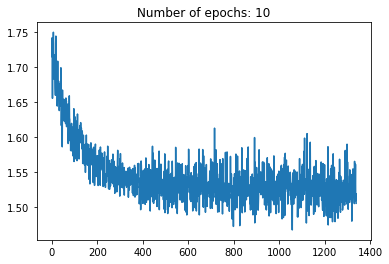

In [18]:
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
torch.use_deterministic_algorithms(True)
torch.manual_seed(42)
np.random.seed(42)

model = Feedforward(dataset.X.shape[1], hidden_size, dataset.num_classes)
criterion = torch.nn.CrossEntropyLoss() #(weight = torch.Tensor([1,0.8,0.3,0.2,0.9]).cuda())
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
model.to(device)
evaluate_model(model, test_loader, device)
model, loss_values = train_model(model, criterion, optimizer, num_epochs, train_loader, device)
evaluate_model(model, test_loader, device)
plt.plot(loss_values)
plt.title(f"Number of epochs: {num_epochs}")
plt.show()

In [ ]:
test_model(model, test_loader, device)

In [ ]:
def predict(row, model):
    row = torch.Tensor([row])
    yhat = model(row)
    yhat = yhat.detach().numpy()
    return yhat